<a href="https://colab.research.google.com/github/rahiakela/nlp-research-and-practice/blob/main/llms-notebooks/02_fine_tuning_llamav2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

**Reference**

https://www.kdnuggets.com/fine-tuning-llamav2-with-qlora-on-google-colab-for-free

In [ ]:
!wget https://github.com/dozed/snli-german/raw/master/snli_1.0_train.csv

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [3]:
import pandas as pd
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

##Data Preparation

In [6]:
data_df = pd.read_csv("snli_1.0_train.csv")
data_df.head()

,sentence1,sentence2,gold_label
0,Eine Person auf einem Pferd springt über ein z...,Eine Person trainiert ihr Pferd für ein Turnier.,neutral
1,Eine Person auf einem Pferd springt über ein z...,Eine Person ist in einem Diner und bestellt ei...,contradiction
2,Eine Person auf einem Pferd springt über ein z...,"Ein Mensch ist im Freien, auf einem Pferd.",entailment
3,Kinder lächeln und winken der Kamera zu.,Sie lächeln ihre Eltern an.,neutral
4,Kinder lächeln und winken der Kamera zu.,Es sind Kinder anwesend.,entailment


<Axes: >

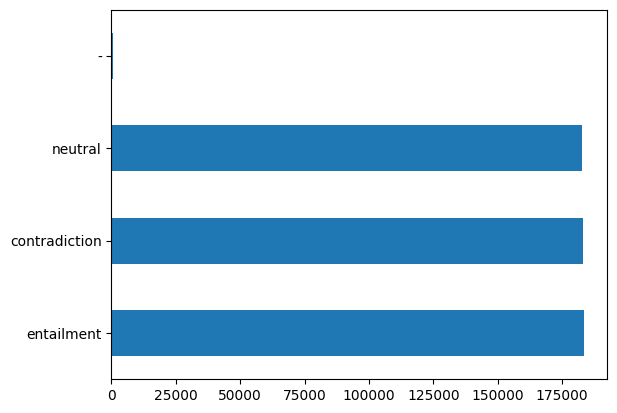

In [5]:
data_df["gold_label"].value_counts().plot(kind="barh")

In [8]:
# let's see a few random contradiction examples
data_df[data_df["gold_label"] == "contradiction"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
367610,Eine einsame Frau benutzt einen großen primiti...,Ein Mann ruft seine Mutter am Telefon an.
377866,Ein Herr in blauer Jacke und khakifarbenen Sho...,Ein Mann füttert einen Pinguin.
81478,Die Menschen sitzen auf einem Balkon mit Blick...,Die Leute stehen auf einem Balkon.
94035,"Bauarbeiter, die Wandfliesen in einem Flur ver...","Menschen, die Häuser in einer leeren Lücke zer..."
91206,Ein Mann in einer schwarzen Lederjacke spielt ...,der Junge hörte Musik.
370693,"Menschen mit Hüten schauen auf etwas, als ein ...",Niemand hat seinen Kopf bedeckt.
143472,Eine Turnerin beugt sich auf einer gelben Matt...,Ein Turner ist auf der Schaukel.
403684,Ein schwarz-weißer Hund rennt auf den Betracht...,Ein gelber Hund jagt rosa Pangolins.
145830,"Kleine Kinder mit dunklen Haaren, gekleidet in...",Die Kinder spielen in einem Klettergerüst.
508634,Der junge Mann wirft einen Fußball auf staubig...,junger Mann isst


In [9]:
# let's see a few random entailment examples
data_df[data_df["gold_label"] == "entailment"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
294076,Koreanische Schüler hören ihrem Lehrer zu.,Die Schüler sind in der Schule.
269640,"Eine Gruppe von Personen, die entweder an eine...",Eine Gruppe von Menschen ist versammelt.
252572,"Zwei Kinder laufen entlang einer Promenade, di...",Zwei Kinder laufen weg.
269599,"Leute, die einen Marathon laufen.",Die Leute laufen eine Straße entlang.
15592,"Oben ohne alter Mann mit Pantoffeln, marinebla...",Der Mann ist im Freien ohne Hemd.
326009,Ein Mann und drei Kinder spielen Volleyball.,Ein Mann und Kinder machen etwas Sport.
81025,"Ein Mann und ein Mädchen in der Ferne, die zu ...",Ein Mann und ein Mädchen spielen Basketball.
411145,Ein junger Mensch schlittert im Schnee einen H...,Ein Mensch schlittert einen Hügel hinunter.
273832,"Ein Mädchen, das mit einem Hund in der Nähe ei...",Das Mädchen ist bei einem Polizeiauto.
89135,Männer spielen mit einem Volleyball in einem P...,Da sind Männer in einem Pool.


In [10]:
# let's see a few random neutral examples
data_df[data_df["gold_label"] == "neutral"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
379605,"Zwei Personen mit Handschuhen und Masken, die ...",Zwei Menschen arbeiten in einem Krankenhaus.
164951,Ein Mann in einem gestreiften Hemd läuft.,Der Mann ist heiß.
535776,Eine Sängerin und Tänzerin steht auf der Bühne...,Eine Sängerin steht auf der Bühne des Jazzfest...
353922,"Menschen, die auf einen Zug warten, der hält.",Der Zug wird nicht anhalten.
204801,Zwei Frauen mit Stethoskopen und ein Mann mit ...,Zwei Frauen haben weiße Stethoskope.
220168,"Ein Mädchen in einem blauen Schläger, das eine...","Ein Mädchen leckt einen Schneebesen, aus dem B..."
168395,"Dies ist eine Gruppe von jungen Männern, die a...",Die Männer stehen auf einem Sandfeld und amüsi...
120367,"Ein Mann, der auf einem blauen Stuhl sitzt und...",Ein berühmter Künstler malt
247901,Quarterback für die University of Florida,Der Quarterback wirft den Ball.
455790,Ein Hund wird mit Wasser besprüht.,Ein Welpe wird mit einem Feuerwehrschlauch bes...


In [11]:
# let's takes only the contradictory sentences and converts the dataset instruct format
def convert_to_instruct_format(row):
  sentence1 = row["sentence1"]
  sentence2 = row["sentence1"]

  prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
  instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
  input = str(sentence1)
  response = f"""```json{{'orignal_sentence':'sentence1', 'generated_negation':'sentence2'}}```"""

  if len(input.strip()) == 0:
    # prompt + 2 new lines + ###instruction + new line + input + new line + ###response
    text = prompt + "\n\n Instruction:\n" + instruction + "\n### Response:\n" + response
  else:
    text = prompt + "\n\n Instruction:\n" + instruction + "\n### Input:\n" + "\n" + "\n### Response:\n" + response

  # we need 4 columns for auto train, instruction, input, output, text
  return pd.Series([instruction, input, response, text])

In [12]:
new_df = data_df[data_df["gold_label"] == "contradiction"][["sentence1", "sentence2"]].apply(convert_to_instruct_format, axis=1)
new_df.columns = ["instruction", "input", "output", "text"]
new_df.to_csv("snli_instruct.csv", index=False)

In [13]:
new_df.head()

,instruction,input,output,text
1,"Given the following sentence, your job is to g...",Eine Person auf einem Pferd springt über ein z...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
5,"Given the following sentence, your job is to g...",Kinder lächeln und winken der Kamera zu.,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
6,"Given the following sentence, your job is to g...",Ein Junge springt auf dem Skateboard in der Mi...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
10,"Given the following sentence, your job is to g...",Ein älterer Mann sitzt mit seinem Orangensaft ...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
13,"Given the following sentence, your job is to g...",Zwei blonde Frauen umarmen sich gegenseitig.,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...


##Fine-tuning